In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class GP:
  def __init__(self, dim, Q, device="cuda" ):
    self.beta = 10.0
    self.dim = dim
    self.device = device
    self.Q = Q

    self.kparam0 = torch.rand(Q, requires_grad=True )
    self.kparam1 = torch.rand(Q, requires_grad=True)
    self.kparam2 = torch.rand(Q, requires_grad=True)

  def k(self, xi, xj):
    k = 0
    for q in range(self.Q):
      k += torch.exp(self.kparam0[q]) * torch.cos(self.kparam1[q]*torch.sum( torch.abs(xi - xj), 2)) * torch.exp( -torch.exp(self.kparam2[q])*torch.sum((xi - xj) * (xi - xj), 2) )
    return k

  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.dim).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def learn(self, xt, yt ):
    N = len(xt)

    self.xt = torch.tensor(xt).reshape(-1,self.dim)
    self.yt = torch.tensor(yt).reshape(N,-1)
    self.yt_t = torch.t( self.yt )

    # to gpu
    self.xt.to(self.device)
    self.yt.to(self.device)
    self.kparam0.to(self.device)
    self.kparam1.to(self.device)
    self.kparam2.to(self.device)

    optimizer = torch.optim.Adam( [self.kparam0, self.kparam1, self.kparam2], lr=0.01)

    for it in range(1000):
        # カーネル行列を定義
        self.K = self.cov( self.xt, self.xt ) + torch.eye(N, N)/self.beta
        self.K_inv = torch.inverse( self.K )

        # 負の対数尤度
        loss = 1/2 * torch.log(torch.det(self.K)) + 1/2 * torch.mm( torch.mm( self.yt_t, self.K_inv ), self.yt )

        # 最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it%100==0:
          print(loss)

  def predict( self, x ):
    x = torch.tensor(x).reshape(-1,self.dim)

    kx = self.cov( x, self.xt )
    k = self.cov( x, x) + 1.0/self.beta

    mu = torch.mm( torch.mm( kx, self.K_inv ), self.yt.reshape(-1,1) )
    sig = k - torch.mm( kx, torch.mm(self.K_inv, torch.t(kx)) )
        
    return mu.detach().numpy().flatten(), sig.diag().detach().numpy().flatten()

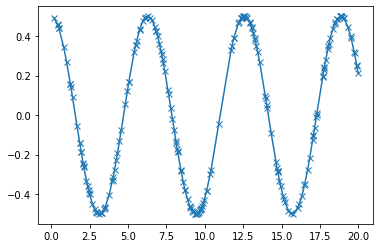

In [2]:
xt = np.sort(np.random.rand(200)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

In [5]:
gp = GP(1, 10, "cpu")
gp.learn( xt.reshape((-1,1)), yt )

tensor([[-100.8499]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-156.5663]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-181.5953]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-194.7523]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-201.3468]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-203.7028]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-204.6826]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-206.8751]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-209.7319]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-211.9090]], dtype=torch.float64, grad_fn=<AddBackward0>)


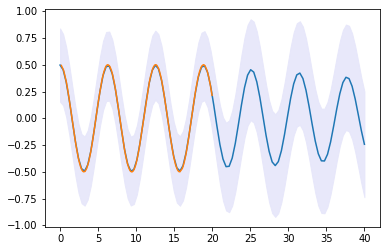

In [6]:
x = np.linspace( 0,40,100 )

mus, sigmas = gp.predict( x.reshape(-1,1) )
plt.plot( x, mus )

y_max = mus + np.sqrt(sigmas.flatten())
y_min = mus - np.sqrt(sigmas.flatten())

plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
plt.plot(xt, yt)
plt.show()